# Movielens
---
Esta base de datos contiene información sobre películas y ratings de distintos usuarios.
Responde a las siguientes preguntas

<div class="panel panel-danger">
    <div class='panel-heading'>
    <h4>Antes de empezar</h4>
    </div>
    <div class='panel-body'>
    <p>Para poder ejecutar queries a la base de datos, necesitamos tener instalado antes el paquete [ipython-sql](https://github.com/catherinedevlin/ipython-sql).
    
    <p>Este paquete nos permite escribir las queries sql en las celdas del notebook y visualizar el resultado como tablas html renderizadas
    <p>Ejecuta `!pip install ipython-sql` si es la primera vez que usas este notebook
    </div>
</div>

<br>

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)

import pandas as pd
import sqlite3

Cargamos la base de datos y mostramos el nombre de sus tablas:

In [2]:
%load_ext sql
%sql sqlite:///data/movies/movielens.sqlite
%sql SELECT name FROM sqlite_master WHERE type='table'

Done.


name
ratings
links
tags
movies


Antes de empezar, recuerda que para ejecutar una query sql en las celdas de los notebooks, debes empezar la celda por `%%sql`. Por ejemplo...

In [3]:
%%sql

SELECT count(*) as num_rows
FROM movies

Done.


num_rows
9125


Recuerda que también puedes realizar queries a la base de datos usango `pandas` y `sqlite3`

---
<div class="panel panel-success">
    <div class='panel-heading'>
    <h4>Empecemos</h4>
    </div>
    <div class='panel-body'>
    <p> Responde a las siguientes preguntas de la base de datos
    </div>
</div>

**1. Nombra las columnas de cada tabla en la base de datos e identifíca las *primary* y *foreign* keys **

Para ver la información de cada tabla, usamos **PRAGMA table_info(table_name)**.

In [4]:
%%sql

PRAGMA table_info('ratings')

Done.


cid,name,type,notnull,dflt_value,pk
0,index,INTEGER,0,None,0
1,userId,INTEGER,0,None,0
2,movieId,INTEGER,0,None,0
3,rating,REAL,0,None,0
4,timestamp,TIMESTAMP,0,None,0


Las *foreign keys* serían **userId** y **movieId**, cada una para sus respectivas tablas de dimensiones *Usuarios* (aunque esta no exista en este dataset) y *Películas*.

La clave primaria sería la unión de **userId** y **movieId**, dado que un usuario solo puede valorar una misma película una única vez. No obstante, vemos que no la tiene creada y, aunque se la podríamos crear con las siguientes sentencias de SQL, no lo vamos a hacer para no afectar a la base de datos original usada en estos ejercicios:

```SQL
CREATE TABLE tmp_ratings (
    `index` INTEGER, 
    userId INTEGER,
    movieId INTEGER,
    rating REAL,
    timestamp TIMESTAMP
);

INSERT INTO tmp_ratings (`index`, userId, movieId, rating, timestamp)
    SELECT `index`, userId, movieId, rating, timestamp FROM ratings;
    
DROP TABLE ratings;

ALTER TABLE tmp_ratings RENAME TO ratings;
```

SQLite no permite hacer modificaciones en la estructura de una tabla una vez creada, por lo que tenemos que crear una tabla auxiliar idéntica a la original, rellenarla con los mismo datos, borrar la original y cambiarle el nombre a la auxiliar.

<br>

In [5]:
%%sql 

PRAGMA table_info('links')

Done.


cid,name,type,notnull,dflt_value,pk
0,index,INTEGER,0,None,0
1,movieId,INTEGER,0,None,0
2,imdbId,INTEGER,0,None,0
3,tmdbId,REAL,0,None,0


**moviedId** es la única *foreign key* de esta tabla. No obstante, también es *clave primaria*, ya que es una relación de 1-1 con la tabla **movies**.

<br>

In [6]:
%%sql

PRAGMA table_info('tags')

Done.


cid,name,type,notnull,dflt_value,pk
0,index,INTEGER,0,None,0
1,userId,INTEGER,0,None,0
2,movieId,INTEGER,0,None,0
3,tag,TEXT,0,None,0
4,timestamp,TIMESTAMP,0,None,0


**userId** y **movieId** son las *foreign key* e **index** la *primary key*, ya que un usuario puede asignarle más de un tag a una misma película.

<br>

In [7]:
%%sql

PRAGMA table_info('movies')

Done.


cid,name,type,notnull,dflt_value,pk
0,index,INTEGER,0,None,0
1,movieId,INTEGER,0,None,0
2,title,TEXT,0,None,0
3,genres,TEXT,0,None,0


**movieId** es la *primary key*. Esta tabla no tiene *foreign key*.

<br>

**2. ¿Cómo evoluciona el rating de '12 Angry Men' a lo largo de los años? Haz un gráfico de la evolución**

Comprobamos qué películas existen llamadas **12 Angry Men**.

In [8]:
%%sql

SELECT movieId, title
FROM movies m
WHERE title LIKE '12 Angry Men%'

Done.


movieId,title
1203,12 Angry Men (1957)
77846,12 Angry Men (1997)


Dado que existen dos, en diferentes años, vamos a comparar sus *ratings* mediante la siguiente *query*. Esta *query* cruza las tablas **movies** y **ratings** para sacar la media de las puntuaciones de cada película, agrupando por título y por año.

In [9]:
%%sql

SELECT title, 
    strftime('%Y', timestamp) AS year,
    avg(rating) AS avg_rating
FROM movies m
INNER JOIN ratings r ON m.movieId = r.movieId
WHERE title LIKE '12 Angry Men%'
GROUP BY title, 
    year
ORDER BY title, year
LIMIT 5

Done.


title,year,avg_rating
12 Angry Men (1957),1996,4.0
12 Angry Men (1957),1997,4.4
12 Angry Men (1957),1998,3.5
12 Angry Men (1957),1999,4.5
12 Angry Men (1957),2000,4.545454545454546


No obstante, para poder hacer una gráfica del resultado de la anterior *query*, hay que crear un dataframe de la siguiente manera realizando exactamente la misma consulta anterior:

In [10]:
conn = sqlite3.connect('data/movies/movielens.sqlite')

query = """
    SELECT title, 
        strftime('%Y', timestamp) AS year,
        avg(rating) AS avg_rating
    FROM movies m
    INNER JOIN ratings r ON m.movieId = r.movieId
    WHERE title LIKE '12 Angry Men%'
    GROUP BY title, 
        year
    ORDER BY title, year
"""

df_film = pd.read_sql(query, conn)
df_film

,title,year,avg_rating
0,12 Angry Men (1957),1996,4.000000
1,12 Angry Men (1957),1997,4.400000
2,12 Angry Men (1957),1998,3.500000
3,12 Angry Men (1957),1999,4.500000
4,12 Angry Men (1957),2000,4.545455
5,12 Angry Men (1957),2001,4.500000
6,12 Angry Men (1957),2002,3.750000
7,12 Angry Men (1957),2003,3.500000
8,12 Angry Men (1957),2004,3.000000
9,12 Angry Men (1957),2005,4.500000


Por último, creamos la gráfica:

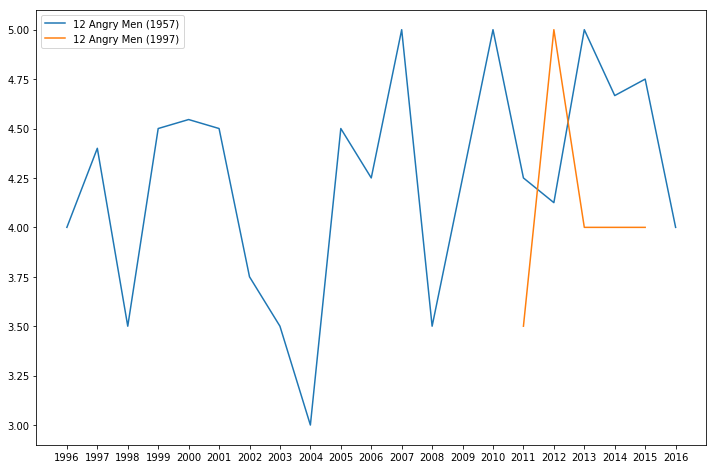

In [11]:
df_1957_film = df_film[df_film.title == '12 Angry Men (1957)']
df_1997_film = df_film[df_film.title == '12 Angry Men (1997)']

plt.plot(df_1957_film.year, df_1957_film.avg_rating, label = '12 Angry Men (1957)')
plt.plot(df_1997_film.year, df_1997_film.avg_rating, label = '12 Angry Men (1997)')
plt.legend()

** 3. ¿Cuál es la película peor valorada de cada año? **

Para poder conocer cuál es la película peor valorada de cada año deberemos usar *subquerys*. Primero, debemos saber la valoración de cada película por año para, finalmente, sacar la valoración mínima agrupando únicamente por año. Hay que tener en cuenta que en caso de que haya dos películas repetidas el mismo año, la función **min** ordena los valores por la primera columna que se especifique en el **group by**, por lo que nos puede llevar a resultados diferentes. Para solucionar esto habría que hacer una *query* mucho más compleja que está fuera del alcance de este ejercicio. No obstante, sí que vamos a mostrar ambos ejemplos.

In [12]:
%%sql

SELECT m.movieId,
    title,
    strftime('%Y', timestamp) AS year,
    min(rating) AS avg_rating
FROM movies m
    INNER JOIN ratings r ON m.movieId = r.movieId
where strftime('%Y', timestamp) = '1996'
    and m.movieId in (42, 737)
group by m.movieId, year

Done.


movieId,title,year,avg_rating
42,Dead Presidents (1995),1996,1.0
737,Barb Wire (1996),1996,1.0


In [13]:
%%sql

SELECT m.movieId,
    title,
    strftime('%Y', timestamp) AS year,
    min(rating) AS avg_rating
FROM movies m
    INNER JOIN ratings r ON m.movieId = r.movieId
where strftime('%Y', timestamp) = '1996'
    and m.movieId in (42, 737)
group by title, year

Done.


movieId,title,year,avg_rating
737,Barb Wire (1996),1996,1.0
42,Dead Presidents (1995),1996,1.0


En las dos *querys* anteriores, la primera está agrupada por **movieId** y **year**, y automáticamente el gestor de BBDD devuelve el resultado ordenado por **movieId**; mientras que en la segunda, se está haciendo una agrupación por **title** y por **year**, devolviendo el resultado ordenador por **title**.

Por lo tanto, mostramos el resultado final de ambas formas a continuación.

In [14]:
%%sql

SELECT title,
    year,
    min(avg_rating) AS rating
FROM (
    SELECT title,
        strftime('%Y', timestamp) AS year,
        avg(rating) AS avg_rating
    FROM movies m
        INNER JOIN ratings r ON m.movieId = r.movieId
    GROUP BY r.movieId, year
)
GROUP BY year
ORDER BY 2

Done.


title,year,rating
Get Shorty (1995),1995,3.0
Dead Presidents (1995),1996,1.0
Powder (1995),1997,1.0
Lawnmower Man 2: Beyond Cyberspace (1996),1998,1.0
Waiting to Exhale (1995),1999,1.0
Cutthroat Island (1995),2000,1.0
Tom and Huck (1995),2001,1.0
Bio-Dome (1996),2002,1.0
Mr. Wrong (1996),2003,0.5
Fair Game (1995),2004,0.5


In [15]:
%%sql

SELECT title,
    year,
    min(avg_rating) AS rating
FROM (
    SELECT title,
        strftime('%Y', timestamp) AS year,
        avg(rating) AS avg_rating
    FROM movies m
        INNER JOIN ratings r ON m.movieId = r.movieId
    GROUP BY title, year
)
GROUP BY year
ORDER BY 2

Done.


title,year,rating
"Fish Called Wanda, A (1988)",1995,3.0
Barb Wire (1996),1996,1.0
Airheads (1994),1997,1.0
American Buffalo (1996),1998,1.0
"Adventures of Elmo in Grouchland, The (1999)",1999,1.0
102 Dalmatians (2000),2000,1.0
"6th Man, The (Sixth Man, The) (1997)",2001,1.0
2 ou 3 choses que je sais d'elle (2 or 3 Things I Know About Her) (1967),2002,1.0
"Angel at My Table, An (1990)",2003,0.5
13 Ghosts (1960),2004,0.5


** 4. ¿Quién es el usuario más activo y desde cuándo lleva activo? **

Para saber el usuario más activo, basta con contar el número de valoraciones que ha hecho cada usuario y, finalmente, coger el que tenga más mediante la función **max**.

In [16]:
%%sql

SELECT userId, 
    max(n_ratings) as n_ratings,
    first_rating
FROM (
    SELECT userId, 
        count(*) as n_ratings,
        min(timestamp) as first_rating
    FROM ratings
    GROUP BY userId
)

Done.


userId,n_ratings,first_rating
547,2391,2000-11-21 03:25:09


** 5. ¿Cuales son sus 5 películas favorítas del año 2016? **

Para realizar este apartado, utilizamos la *query* usada en el ejercicio anterior para extraer el *id* del usuario más activo (para no hacer *[Hard-Code](https://es.wikipedia.org/wiki/Hard_code)*). Esta la unimos con **movies** y **ratings** para conocer cuáles han sido sus 5 películas favoritas del 2016.

In [17]:
%%sql

SELECT m.title, 
    u.userId, 
    r.rating, 
    r.timestamp
FROM movies m
INNER JOIN ratings r 
    ON r.movieId = m.movieId AND strftime('%Y', r.timestamp) = '2016'
INNER JOIN (
    SELECT userId,
        max(n_ratings) as n_ratings
    FROM (
        SELECT userId, 
            count(*) as n_ratings
        FROM ratings
        GROUP BY userId
    )
) u 
    ON r.userId = u.userId
ORDER BY r.rating DESC
LIMIT 5

Done.


title,userId,rating,timestamp
Making a Murderer (2015),547,5.0,2016-02-02 17:03:02
The Beatles: Eight Days a Week - The Touring Years (2016),547,5.0,2016-10-14 04:27:19
"Lust, Caution (Se, jie) (2007)",547,4.5,2016-08-30 15:10:39
"Impossible, The (Imposible, Lo) (2012)",547,4.5,2016-03-12 14:28:34
Ex Machina (2015),547,4.5,2016-01-28 17:08:05


**6. Haz una gráfica de como evolucionan el número de películas que ve cada año y la nota media. **

Para esta parte, hacemos dos pequeñas modificaciones en la *query* anterior para agrupar por año y extraer el número de películas que ve cada año el usuario más activo y la nota media. Además, no es necesario unir con la tabla **movies**.

In [18]:
%%sql

SELECT strftime('%Y', r.timestamp) as year, 
    count(*) as n_films,
    avg(r.rating) as avg_rating
FROM ratings r 
INNER JOIN (
    SELECT userId,
        max(n_ratings) as n_ratings
    FROM (
        SELECT userId, 
            count(*) as n_ratings
        FROM ratings
        GROUP BY userId
    )
) u 
    ON r.userId = u.userId
GROUP BY year
ORDER BY year

Done.


year,n_films,avg_rating
2000,212,4.080188679245283
2001,240,3.2375
2002,269,3.0185873605947955
2003,301,3.2425249169435215
2004,202,2.985148514851485
2005,193,3.349740932642487
2006,93,3.252688172043011
2007,153,3.3333333333333335
2008,141,3.4539007092198584
2009,95,3.3842105263157896


Finalmente, pasamos el resultado de esta query a un dataframe para poder realizar la gráfica:

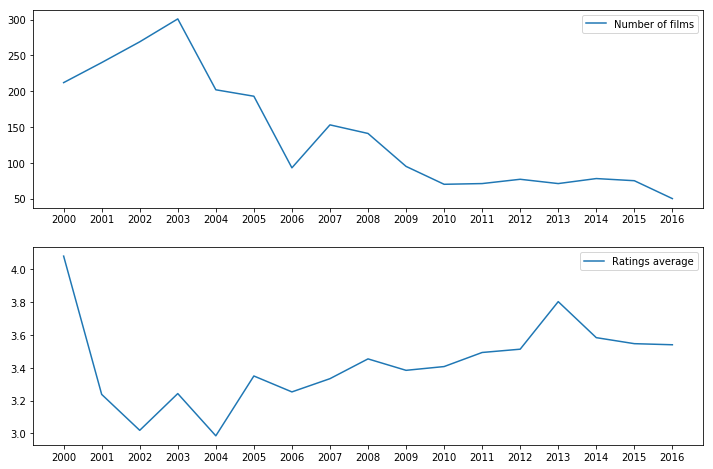

In [19]:
conn = sqlite3.connect('data/movies/movielens.sqlite')

query = """
    SELECT strftime('%Y', r.timestamp) as year, 
        count(*) as n_films,
        avg(r.rating) as avg_rating
    FROM ratings r 
    INNER JOIN (
        SELECT userId,
            max(n_ratings) as n_ratings
        FROM (
            SELECT userId, 
                count(*) as n_ratings
            FROM ratings
            GROUP BY userId
        )
    ) u 
        ON r.userId = u.userId
    GROUP BY year
"""

df_by_year = pd.read_sql(query, conn)

fig, ax = plt.subplots(ncols=1, nrows=2)

ax[0].plot(df_by_year.year, df_by_year.n_films, label = 'Number of films')
ax[0].legend()
ax[1].plot(df_by_year.year, df_by_year.avg_rating, label = 'Ratings average')
ax[1].legend()